# PTC Reconstruction $\chi^2$ test

In [1]:
import os
import numpy as np
import glob
import re
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
from matplotlib.pyplot import cm
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

#repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml"
repo_path = "/sdf/group/rubin/repo/main/"
butler = Butler(repo_path)
registry = butler.registry

def tile_array(in_array):
        """Given an input quarter-image, tile/mirror it and return full image.

        Given a square input of side-length n, of the form

        input = array([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]])

        return an array of size 2n-1 as

        output = array([[ 9,  8,  7,  8,  9],
                        [ 6,  5,  4,  5,  6],
                        [ 3,  2,  1,  2,  3],
                        [ 6,  5,  4,  5,  6],
                        [ 9,  8,  7,  8,  9]])

        Parameters
        ----------
        input : `np.array`, (N, N)
            The square input quarter-array

        Returns
        -------
        output : `np.array`, (2*N + 1, 2*N + 1)
            The full, tiled array
        """
        assert(in_array.shape[0] == in_array.shape[1])
        length = in_array.shape[0] - 1
        output = np.zeros((2*length + 1, 2*length + 1))

        for i in range(length + 1):
            for j in range(length + 1):
                output[i + length, j + length] = in_array[i, j]
                output[-i + length, j + length] = in_array[i, j]
                output[i + length, -j + length] = in_array[i, j]
                output[-i + length, -j + length] = in_array[i, j]
        return output

# Covariance Model Sampling

In [2]:
registry.refresh()



{'R03_S12': {'C10': 64936.840978549466, 'C11': 60855.741786600076, 'C12': 60585.03770022552, 'C13': 60392.65820043784, 'C14': 61670.103884419754, 'C15': 56119.281173966745, 'C16': 61088.02903653129, 'C17': 62342.83677956836, 'C07': 63434.22006125949, 'C06': 60328.45729637455, 'C05': 58971.13488433799, 'C04': 59442.10332554949, 'C03': 59534.34675650128, 'C02': 56119.281173966745, 'C01': 58653.91137984125, 'C00': 61580.913538388806}, 'R24_S11': {'C10': 62050.38094162392, 'C11': 62239.20611061358, 'C12': 63215.74110862148, 'C13': 64176.13820047512, 'C14': 63747.87951652734, 'C15': 63542.748400058255, 'C16': 64173.610552334314, 'C17': 61753.16910805145, 'C07': 59093.879493983724, 'C06': 63665.234462799766, 'C05': 60938.03959347532, 'C04': 61949.71878291115, 'C03': 61764.45497829913, 'C02': 60838.81884288167, 'C01': 54468.198355382316, 'C00': 59403.1682822884}, 'R02_S00': {'C10': 80099.695, 'C11': 80099.695, 'C12': 80099.695, 'C13': 80099.695, 'C14': 80099.695, 'C15': 80099.695, 'C16': 8009

/lscratch/abrought/ipykernel_2463584/512122510.py:271: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(factors[indxs], chisqs[indxs], "o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
/lscratch/abrought/ipykernel_2463584/512122510.py:278: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
/lscratch/abrought/ipykernel_2463584/512122510.py:278: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.

R24-S11 29468.515689691616 19680.63660694479
[1245.02767976 1152.87218027 1238.35570729 1478.8377987  1856.62555284
 2356.87058795]
['ptc.R02-S00.bfcorrected.60000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R02-S00.bfcorrected.30000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R02-S00.bfcorrected.10000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R02-S00.bfcorrected.50000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R02-S00.bfcorrected.40000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R02-S00.bfcorrected.20000adu.newpcti.nonFluxConserving.bfThreshold10']


/lscratch/abrought/ipykernel_2463584/512122510.py:271: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(factors[indxs], chisqs[indxs], "o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
/lscratch/abrought/ipykernel_2463584/512122510.py:278: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
/lscratch/abrought/ipykernel_2463584/512122510.py:278: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.

R02-S00 59812.95828015405 35498.76110956785
[3399.22991123 1591.24767959 1227.65332778 1391.89437209 1946.35340262
 2933.28033715]
['ptc.R21-S02.bfcorrected.10000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R21-S02.bfcorrected.20000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R21-S02.bfcorrected.40000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R21-S02.bfcorrected.60000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R21-S02.bfcorrected.50000adu.newpcti.nonFluxConserving.bfThreshold10', 'ptc.R21-S02.bfcorrected.30000adu.newpcti.nonFluxConserving.bfThreshold10']


/lscratch/abrought/ipykernel_2463584/512122510.py:271: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(factors[indxs], chisqs[indxs], "o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
/lscratch/abrought/ipykernel_2463584/512122510.py:278: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
/lscratch/abrought/ipykernel_2463584/512122510.py:278: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.

R21-S02 33595.47946926604 22475.848433244264
[1313.25936765 1152.04839378 1204.18659313 1437.90692345 1838.48210563
 2360.2337632 ]


/lscratch/abrought/ipykernel_2463584/512122510.py:271: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(factors[indxs], chisqs[indxs], "o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
/lscratch/abrought/ipykernel_2463584/512122510.py:278: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
/lscratch/abrought/ipykernel_2463584/512122510.py:278: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.

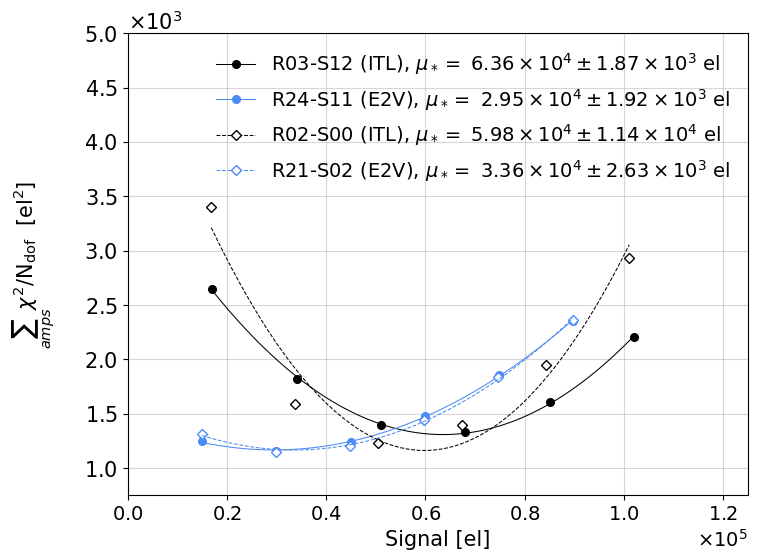

In [9]:
import os
import numpy as np
import glob
import re
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
from matplotlib.pyplot import cm
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

repo_path = "/sdf/group/rubin/repo/main/"
butler = Butler(repo_path)
registry = butler.registry

chisq_signal_cutoff = 5e4 # adu

pcti = {'R03_S12': {'C10': 64936.840978549466, 'C11': 60855.741786600076, 'C12': 60585.03770022552, 'C13': 60392.65820043784, 'C14': 61670.103884419754, 'C15': 56119.281173966745, 'C16': 61088.02903653129, 'C17': 62342.83677956836, 'C07': 63434.22006125949, 'C06': 60328.45729637455, 'C05': 58971.13488433799, 'C04': 59442.10332554949, 'C03': 59534.34675650128, 'C02': 56119.281173966745, 'C01': 58653.91137984125, 'C00': 61580.913538388806}, 
        'R24_S11': {'C10': 62050.38094162392, 'C11': 62239.20611061358, 'C12': 63215.74110862148, 'C13': 64176.13820047512, 'C14': 63747.87951652734, 'C15': 63542.748400058255, 'C16': 64173.610552334314, 'C17': 61753.16910805145, 'C07': 59093.879493983724, 'C06': 63665.234462799766, 'C05': 60938.03959347532, 'C04': 61949.71878291115, 'C03': 61764.45497829913, 'C02': 60838.81884288167, 'C01': 54468.198355382316, 'C00': 59403.1682822884},
        'R02_S00': {'C10': 80099.695, 'C11': 80099.695, 'C12': 80099.695, 'C13': 80099.695, 'C14': 80099.695, 'C15': 80099.695, 'C16': 80099.695, 'C17': 80099.695, 'C07': 80099.695, 'C06': 80099.695, 'C05': 80099.695, 'C04': 80099.695, 'C03': 80099.695, 'C02': 80099.695, 'C01': 80099.695, 'C00': 80099.695},
        'R21_S02': {'C10': 73349.6, 'C11': 73349.6, 'C12': 73349.6, 'C13': 73349.6, 'C14': 73349.6, 'C15': 73349.6, 'C16': 73349.6, 'C17': 73349.6, 'C07': 73349.6, 'C06': 73349.6, 'C05': 73349.6, 'C04': 73349.6, 'C03': 73349.6, 'C02': 73349.6, 'C01': 73349.6, 'C00': 73349.6}}
                    

pcti_cutoff =  {"R03_S12": 60000.,
                "R24_S11": 60000.,
                "R21_S02": 50000.,
                "R02_S00": 50000.}
print(pcti)

def bin_along_x(x, y, nbins, range_x):
    from scipy.stats import binned_statistic
    d, edges, _ = binned_statistic(x,y, statistic='mean', bins=nbins, range=range_x)
    return 0.5 * (edges[1:] + edges[:-1]), d

def fit_chi2_ndof(ptc, det):
        """
        returns the array of chi2/ndof contributions indexed by i and j 
    
        """
        uncorrected_ptc_col = ""
        if det==9:
            uncorrected_ptc_col = "u/abrought/BF/2023.07.19/ptc.R02-S00.trunc_to_pcti.fullnoisematrix"
        elif det == 23:
            uncorrected_ptc_col = "u/abrought/BF/2023.10.09/ptc.R03-S12.trunc_to_pcti"
        elif det==83:
            uncorrected_ptc_col = "u/abrought/BF/2023.07.19/ptc.R21-S02.trunc_to_pcti.fullnoisematrix"
        elif det==112:
            uncorrected_ptc_col = "u/abrought/BF/2023.10.09/ptc.R24-S11.trunc_to_pcti"
        uncorrected_ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=uncorrected_ptc_col)
        
        chi2_ndof_all = []
        bin_along_x = ()
        for i, ampobj in enumerate(camera[0].getAmplifiers()):
            if det==23:
                s = "R03_S12"
            elif det==112:
                s = "R24_S11"
            elif det==83:
                s = "R21_S02"
            elif det==9:
                s="R02_S00"
            
            amp = ampobj.getName()
            if det==23 and amp=='C15':
                continue
            #if det==112 and amp=='C12':
            #    continue
            gain = uncorrected_ptc.gain[amp]
            n = uncorrected_ptc.noiseMatrix[amp][0][0]
            if np.isnan(n):
                n = ptc.noise[amp]**2
            #print(f"NOISE {det}", amp, ptc.noiseMatrix[amp][0][0], ptc.noise[amp])
            expIdMask = ptc.expIdMask[amp]
            #print(np.min(ptc.rawMeans[amp]), np.max(ptc.rawMeans[amp]))
            # 1.0*pcti[s][amp]*gain
            mask2 = (ptc.rawMeans[amp]*gain > 0) * (ptc.rawMeans[amp]*gain < .75e5)
            if det==112 or det==83:
                mask2 = (ptc.rawMeans[amp]*gain > 0) * (ptc.rawMeans[amp]*gain < .35e5)
            mask3 = expIdMask * mask2
            
            data = (ptc.covariances[amp][mask3] - n/gain**2) * (gain**2) # same 
            if det==83:
                data = (ptc.covariances[amp][mask3] - n/gain**2)* (gain**2) 
            model = np.zeros(data.shape)
            for f in range(model.shape[0]):
                model[f] = np.full(model[f].shape, ptc.rawMeans[amp][mask3][f] * gain)
            w = (ptc.covariancesSqrtWeights[amp][mask3] / gain)**2
            #print(data[0], model[0])
            #w = np.ones(ptc.covariancesSqrtWeights[amp][mask3].shape)
            mask = w != 0
            ndof = mask.sum(axis=0)-2
            # for 0,0, count-3 is more accurate:
            ndof[0,0] -= 1
            for i in range(ndof.shape[0]):
                for j in range(ndof.shape[1]):
                    if not i==0 and not j==0:
                        ndof[i][j] *= 2
                        
            chi2_ndof = (((model-data)**2)*w).sum(axis=0)/ndof
            # handle potentially pathological cases
            chi2_ndof[np.isnan(chi2_ndof)] = -0.1
            #print("CHI2 DIM",chi2_ndof.shape) 
            chi2_ndof_all.append(chi2_ndof[0,0])
        
        return np.sum(chi2_ndof_all)
    
import math

def signif(x, digits=3):
    if x == 0 or not math.isfinite(x):
        return x
    digits -= math.ceil(math.log10(abs(x)))
    return int(round(x, digits))

def latex_float(f):
    float_str = "{0:.3g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format("{0:.2f}".format(float(base)), int(exponent))
    else:
        return float_str
    

    
def get_data_points(sensor):
    from scipy.stats import chisquare
    
    def cs(obs, exp):
        return chisquare(obs, np.sum(obs)/np.sum(exp) * exp)
    if sensor in ['R21-S02', 'R02-S00']:
        collections = os.listdir("/sdf/group/rubin/repo/main/u/abrought/BF/2023.07.19/")
    else:
        #     collections = os.listdir("/sdf/group/rubin/repo/main/u/abrought/BF/2023.09.15/")
        collections = os.listdir("/sdf/group/rubin/repo/main/u/abrought/BF/2023.10.09/")
    #if sensor in ['R21-S02']:
    #    collections = os.listdir("/sdf/group/rubin/repo/main/u/abrought/BF/2023.07.19/")
    if sensor in ['R24-S11']:
        collections = [f for f in collections if "ptc" in f]
        collections = [f for f in collections if "adu" in f]
        collections = [f for f in collections if "new" in f]
        collections = [f for f in collections if f"{sensor}" in f]
        #collections = [f for f in collections if "50000" not in f]
        #collections = [f for f in collections if "40000" not in f]
        collections = [f for f in collections if "70000" not in f]
        collections = [f for f in collections if "80000" not in f]
    elif sensor in ['R02-S00']:
        collections = [f for f in collections if "ptc" in f]
        collections = [f for f in collections if "adu" in f]
        collections = [f for f in collections if f"{sensor}" in f]
        #collections = [f for f in collections if "40000" not in f]
        #collections = [f for f in collections if "10000" not in f]
        #collections = [f for f in collections if "60000" not in f]
        #collections = [f for f in collections if "70000" not in f]
        #collections = [f for f in collections if "80000" not in f]
    elif sensor in ['R03-S12']:
        collections = [f for f in collections if "ptc" in f]
        collections = [f for f in collections if "adu" in f]
        collections = [f for f in collections if "new" in f]
        collections = [f for f in collections if f"{sensor}" in f]
        #collections = [f for f in collections if "20000" not in f]
        #collections = [f for f in collections if "50000" not in f]
    else:
        collections = [f for f in collections if "ptc" in f]
        collections = [f for f in collections if "adu" in f]
        collections = [f for f in collections if f"{sensor}" in f]
        #collections = [f for f in collections if "40000" not in f]
        #collections = [f for f in collections if "60000" not in f]
        #collections = [f for f in collections if "70000" not in f]
        #collections = [f for f in collections if "80000" not in f]
    
    #if sensor in ['R03-S12']:
    #    collections = [f for f in collections if "40000" not in f]
    
    # if sensor in ['R02-S00']:
    #     collections = [f for f in collections if "10000" not in f]

    
    collections = [f for f in collections if "nonFluxConserving" in f]
    collections = [f for f in collections if "bfThreshold10" in f]

    print(collections)

    if sensor in ['R21-S02', 'R02-S00']:
        collections = np.sort(["u/abrought/BF/2023.07.19/" + f for f in collections])
    else:
        #     collections = np.sort(["u/abrought/BF/2023.09.15/" + f for f in collections])
        collections = np.sort(["u/abrought/BF/2023.10.09/" + f for f in collections])

    #if sensor in ['R21-S02']:
    #    collections = np.sort(["u/abrought/BF/2023.07.19/" + f for f in collections])
    #else:
    ########collections = np.sort(["u/abrought/BF/2023.10.09/" + f for f in collections])
    #print(collections)

    #print([c.replace("adu.newpcti.nonFluxConserving.bfThreshold10", "") for c in collections])
    factors = np.asarray([float(col.replace("adu.newpcti.nonFluxConserving.bfThreshold10", "")[49:]) for col in collections])
    
    sensorid = sensor.replace("-","_")
    det = camera.get(sensorid).getId()
    
    #uncorrected_ptc = ptc
    #if det==23 or det==112:
    #    uncorrected_ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=f'u/abrought/BF/2023.07.19/ptc.{sensor}.trunc_to_newpcti.fullnoisematrix'.format(sensor))
    #else:
    #    uncorrected_ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=f'u/abrought/BF/2023.07.19/ptc.{sensor}.trunc_to_pcti.fullnoisematrix'.format(sensor))

    
    chisqs = []
    for j, collection in enumerate(collections):
        ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=collection)
        uncorrected_ptc_col = ""
        if det==9:
            uncorrected_ptc_col = "u/abrought/BF/2023.07.19/ptc.R02-S00.trunc_to_pcti.fullnoisematrix"
        elif det == 23:
            uncorrected_ptc_col = "u/abrought/BF/2023.10.09/ptc.R03-S12.trunc_to_pcti"
        elif det==83:
            uncorrected_ptc_col = "u/abrought/BF/2023.07.19/ptc.R21-S02.trunc_to_pcti.fullnoisematrix"
        elif det==112:
            uncorrected_ptc_col = "u/abrought/BF/2023.10.09/ptc.R24-S11.trunc_to_pcti"
        uncorrected_ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=uncorrected_ptc_col)
        
        mean_gain = np.array(list(uncorrected_ptc.gain.values())).mean()
        factors[j] = factors[j] * mean_gain
        chisq = fit_chi2_ndof(ptc, det)
        chisqs.append(chisq)

        
    chisqs = np.asarray(chisqs)
    factors = np.asarray(factors)
    
    def f(x,a,b,c):
        return a*x**2 + b*x + c
    
    x = np.linspace(np.min(factors), np.max(factors), 10000)
    #print(np.asarray(factors), chisqs)
    popt, pcov = curve_fit(f, np.asarray(factors), chisqs)#, sigma=1/np.sqrt(np.asarray(factors)))
    perr = np.sqrt(np.diag(pcov))
    a,b,c = popt
    mean_gain = np.array(list(uncorrected_ptc.gain.values())).mean()
    
    #print(sensor, mean_gain * 
    
    return factors, chisqs, (a,b,c), perr, np.array(list(uncorrected_ptc.gain.values())).mean()
    

sensors = [  'R03-S12' ,'R24-S11', 'R02-S00','R21-S02']

sensortype = ['(ITL)', '(E2V)','(ITL)','(E2V)']
colors  = ['k', '#4c8bf5', 'k', '#4c8bf5']
linefmt = [ "-", "-", "--", "--"]
markers = [ "o", "o", "D", "D"]
face = ['k','#4c8bf5','w','w']

plt.figure(figsize=(8,6))
for i, sensor in enumerate(sensors):

    factors, chisqs, (A,B,C), perr, mean_gains = get_data_points(sensor)
    dA,dB = perr[0],perr[1]
    err = np.sqrt(((0.5 *(B / (A**2))) * dA)**2 + ((-0.5/A) * dB)**2)
    print(sensor, -B / (2*A),  (-B / (2*A)) /mean_gains)
    indxs = np.argsort(factors)
    print(chisqs[indxs])
    plt.plot(factors[indxs], chisqs[indxs], "o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
    x = np.linspace(np.min(factors), np.max(factors), 10000)

    #label = f"{sensor} {sensortype[i]}, $\mathrm{{argmin}}[\,\chi^2(\mu)\,] =  ${round(-B / (2*A), -1)}$\pm${round(err,-1)}"
    label = f"{sensor} {sensortype[i]}, $\mu_* =$ ${latex_float(-B / (2*A))}\pm{latex_float(err)}$ el"
    #label = f"{sensor} {sensortype[i]}, ${latex_float(-B / (2*A))}$"
    plt.plot(x, A*x**2 + B*x + C, color=colors[i], linestyle=linefmt[i],linewidth=0.75)
    plt.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.gca().ticklabel_format(useMathText=True)
plt.ylabel(r'$\sum_{amps}\chi^2 /\mathrm{N_{dof}}$  [el$^2$]', rotation=90, labelpad=20)
plt.xlabel('Signal [el]')
#plt.ylim(7500,37000)
plt.grid(visible=True,alpha=0.5)
plt.legend(frameon=False, fontsize=14)
plt.ylim(0.75e3,5e3)
plt.xlim(0,1.25e5)

plt.savefig("/sdf/home/a/abrought/run5/BF/plots/cov_model_ptc_scan.png", bbox_inches='tight')


# Calculate per amplifier values

['u/abrought/BF/2023.10.09/ptc.R03-S12.bfcorrected.10000adu.newpcti.nonFluxConserving.bfThreshold10'
 'u/abrought/BF/2023.10.09/ptc.R03-S12.bfcorrected.20000adu.newpcti.nonFluxConserving.bfThreshold10'
 'u/abrought/BF/2023.10.09/ptc.R03-S12.bfcorrected.30000adu.newpcti.nonFluxConserving.bfThreshold10'
 'u/abrought/BF/2023.10.09/ptc.R03-S12.bfcorrected.50000adu.newpcti.nonFluxConserving.bfThreshold10']
R03-S12 C10 -7726.818048849314 e -> -4654.324571391719  adu
R03-S12 C11 -3704.641854128629 e -> -2192.6044700965194  adu


/lscratch/abrought/ipykernel_107842/4112044223.py:209: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(factors[indxs], chisqs[indxs],"o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
/lscratch/abrought/ipykernel_107842/4112044223.py:216: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
/lscratch/abrought/ipykernel_107842/4112044223.py:216: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,ma

R03-S12 C12 -2556.7605913621196 e -> -1520.7001996117242  adu
R03-S12 C13 -2489.9624443731877 e -> -1478.7628824918079  adu
R03-S12 C14 2653.867933051722 e -> 1580.2422610872272  adu
R03-S12 C15 -3857.5082506838426 e -> -2298.477540475709  adu
R03-S12 C16 1249.651699867558 e -> 748.1110058601702  adu
R03-S12 C17 902.0003539922342 e -> 545.1831467060097  adu
R03-S12 C07 -5649.100642206513 e -> -3539.2411825645704  adu
R03-S12 C06 -708.3504644343792 e -> -407.3147019093113  adu
R03-S12 C05 6586.925435823168 e -> 3735.856569584265  adu
R03-S12 C04 -6800.400042452265 e -> -3904.8339832262754  adu
R03-S12 C03 1706.7662804653444 e -> 978.3013428125233  adu
R03-S12 C02 -1990.756681904629 e -> -1149.3739693317889  adu
R03-S12 C01 163.8258717420864 e -> 93.13948138210966  adu
R03-S12 C00 767.5907788460714 e -> 436.8056709676495  adu

R03-S12
{'C10': -4654.324571391719, 'C11': -2192.6044700965194, 'C12': -1520.7001996117242, 'C13': -1478.7628824918079, 'C14': 1580.2422610872272, 'C15': -2298.477

/lscratch/abrought/ipykernel_107842/4112044223.py:209: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(factors[indxs], chisqs[indxs],"o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
/lscratch/abrought/ipykernel_107842/4112044223.py:216: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
/lscratch/abrought/ipykernel_107842/4112044223.py:216: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,ma

R02-S00 C10 90481.37768741275 e -> 54848.98541036251  adu
R02-S00 C11 81914.04022880516 e -> 49724.14100793665  adu
R02-S00 C12 95104.80794509889 e -> 57308.50368651031  adu
R02-S00 C13 83967.28727418628 e -> 50740.551108068714  adu
R02-S00 C14 82749.4416062685 e -> 50248.20608677829  adu
R02-S00 C15 60134.21021829741 e -> 36489.685055238806  adu
R02-S00 C16 83113.20182397046 e -> 50559.20466799462  adu
R02-S00 C17 61176.67391109148 e -> 37330.37216774129  adu
R02-S00 C07 87456.12965732632 e -> 51725.83583261  adu
R02-S00 C06 86445.71829724777 e -> 49866.98694683201  adu
R02-S00 C05 79331.50608989841 e -> 45747.32747096385  adu
R02-S00 C04 77824.65586828222 e -> 45188.58279494597  adu
R02-S00 C03 106290.30411645955 e -> 61798.78372830925  adu
R02-S00 C02 89985.4886740457 e -> 51679.521259541616  adu
R02-S00 C01 82908.02794899531 e -> 48400.39677015937  adu
R02-S00 C00 79233.32992660289 e -> 46552.777782858975  adu

R02-S00
{'C10': 54848.98541036251, 'C11': 49724.14100793665, 'C12': 573

/lscratch/abrought/ipykernel_107842/4112044223.py:209: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(factors[indxs], chisqs[indxs],"o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
/lscratch/abrought/ipykernel_107842/4112044223.py:216: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
/lscratch/abrought/ipykernel_107842/4112044223.py:216: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,ma

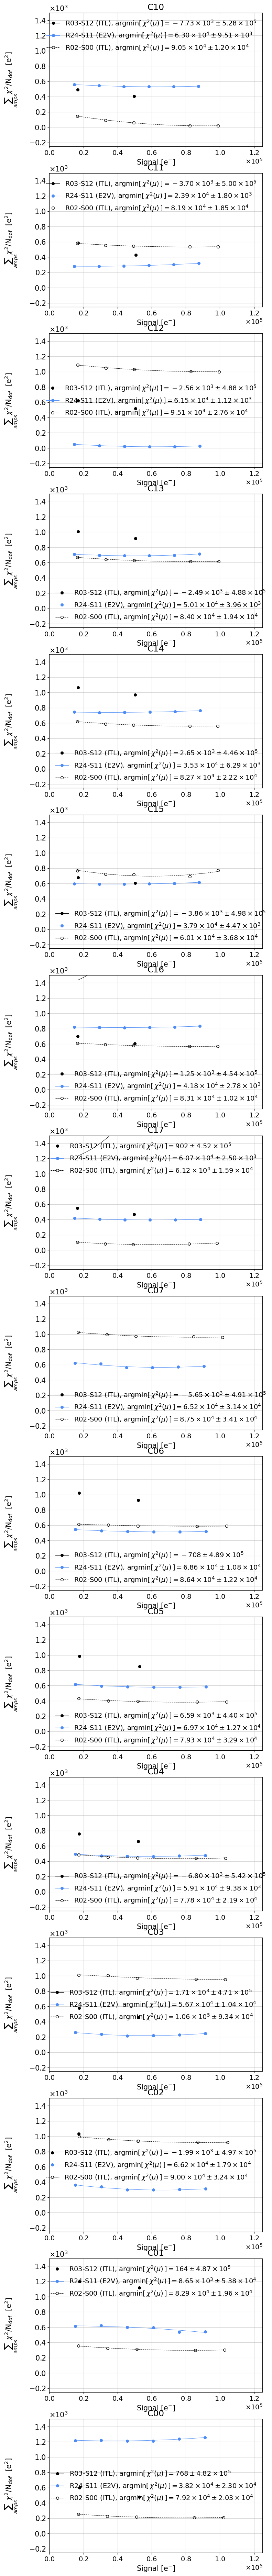

In [31]:
import os
import numpy as np
import glob
import re
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
from matplotlib.pyplot import cm
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

repo_path = "/sdf/group/rubin/repo/main/"
butler = Butler(repo_path)
registry = butler.registry

chisq_signal_cutoff = 5e4 # adu

def bin_along_x(x, y, nbins, range_x):
    from scipy.stats import binned_statistic
    d, edges, _ = binned_statistic(x,y, statistic='mean', bins=nbins, range=range_x)
    return 0.5 * (edges[1:] + edges[:-1]), d

def fit_chi2_ndof(ptc, det):
        """
        returns the array of chi2/ndof contributions indexed by i and j 
        """
        chi2_ndof_all = []
        chi2_dict = dict()
        bin_along_x = ()
        for i, ampobj in enumerate(camera[0].getAmplifiers()):
            amp = ampobj.getName()
            #if det==23 and amp=='C15':
            #    continue
            #if det==112 and amp=='C12':
            #    continue
            gain = ptc.gain[amp]
            expIdMask = ptc.expIdMask[amp]
            #print(np.min(ptc.rawMeans[amp]), np.max(ptc.rawMeans[amp]))
            mask2 = (ptc.rawMeans[amp]*gain < 0.75e5)# * (ptc.rawMeans[amp]*gain > 0.25e5)
            if det==112 or det==9:
                mask2 = (ptc.rawMeans[amp]*gain < 0.25e5) #* (ptc.rawMeans[amp]*gain > 0.25e5)
            mask3 = expIdMask * mask2
            
            data = ptc.covariances[amp][mask3] * (gain**2) # same 
            model = np.zeros(data.shape)
            for f in range(model.shape[0]):
                model[f] = np.full(model[f].shape, ptc.rawMeans[amp][mask3][f] * gain)
            w = (ptc.covariancesSqrtWeights[amp][mask3] / gain)**2
            #w = np.ones(ptc.covariancesSqrtWeights[amp][mask3].shape)
            mask = w != 0
            ndof = mask.sum(axis=0)-2
            # for 0,0, count-3 is more accurate:
            ndof[0,0] -= 1
            for i in range(ndof.shape[0]):
                for j in range(ndof.shape[1]):
                    if not i==0 and not j==0:
                        ndof[i][j] *= 2
                        
            chi2_ndof = (((model-data)**2)*w).sum(axis=0)/ndof
            # handle potentially pathological cases
            chi2_ndof[np.isnan(chi2_ndof)] = -0.1
            #print("CHI2 DIM",chi2_ndof.shape) 
            chi2_ndof_all.append(chi2_ndof[0,0])
            chi2_dict[amp] = chi2_ndof[0,0]
            
        return chi2_dict
    
import math

def signif(x, digits=3):
    if x == 0 or not math.isfinite(x):
        return x
    digits -= math.ceil(math.log10(abs(x)))
    return int(round(x, digits))

def latex_float(f):
    float_str = "{0:.3g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format("{0:.2f}".format(float(base)), int(exponent))
    else:
        return float_str
    

    
def get_data_points(sensor):
    from scipy.stats import chisquare
    
    if sensor in ['R02-S00', 'R21-S02']:
        collections = os.listdir("/sdf/group/rubin/repo/main/u/abrought/BF/2023.07.19/")
    else:
        collections = os.listdir("/sdf/group/rubin/repo/main/u/abrought/BF/2023.09.15/")
        
    collections = os.listdir("/sdf/group/rubin/repo/main/u/abrought/BF/2023.10.09/")
    if sensor in ['R03-S12','R24-S11']:
        collections = [f for f in collections if "ptc" in f]
        collections = [f for f in collections if "adu" in f]
        collections = [f for f in collections if "new" in f]
        collections = [f for f in collections if f"{sensor}" in f]
        #collections = [f for f in collections if "50000" not in f]
        #collections = [f for f in collections if "40000" not in f]
        collections = [f for f in collections if "70000" not in f]
        collections = [f for f in collections if "80000" not in f]
    elif sensor in ['R02-S00']:
        collections = [f for f in collections if "ptc" in f]
        collections = [f for f in collections if "adu" in f]
        collections = [f for f in collections if f"{sensor}" in f]
        collections = [f for f in collections if "40000" not in f]
        #collections = [f for f in collections if "60000" not in f]
        #collections = [f for f in collections if "70000" not in f]
        #collections = [f for f in collections if "80000" not in f]
    else:
        collections = [f for f in collections if "ptc" in f]
        collections = [f for f in collections if "adu" in f]
        collections = [f for f in collections if f"{sensor}" in f]
        #collections = [f for f in collections if "40000" not in f]
        #collections = [f for f in collections if "60000" not in f]
        #collections = [f for f in collections if "70000" not in f]
        #collections = [f for f in collections if "80000" not in f]
    
    if sensor in ['R03-S12']:
        collections = [f for f in collections if "40000" not in f]

    
    collections = [f for f in collections if "nonFluxConserving" in f]
    collections = [f for f in collections if "bfThreshold10" in f]

    collections = np.sort(["u/abrought/BF/2023.10.09/" + f for f in collections])
    # if sensor in ['R02-S00', 'R21-S02']:
    #     collections = np.sort(["u/abrought/BF/2023.07.19/" + f for f in collections])
    # else:
    #     collections = np.sort(["u/abrought/BF/2023.09.15/" + f for f in collections])
    
    print(collections)

    factors = np.asarray([float(col.replace("adu.newpcti.nonFluxConserving.bfThreshold10", "")[49:]) for col in collections])
    
    sensorid = sensor.replace("-","_")
    det = camera.get(sensorid).getId()
    
    #uncorrected_ptc = ptc
    #if det==23 or det==112:
    #    uncorrected_ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=f'u/abrought/BF/2023.07.19/ptc.{sensor}.trunc_to_newpcti.fullnoisematrix'.format(sensor))
    #else:
    #    uncorrected_ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=f'u/abrought/BF/2023.07.19/ptc.{sensor}.trunc_to_pcti.fullnoisematrix'.format(sensor))

    
    chisqs = []
    for j, collection in enumerate(collections):
        ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=collection)
        chisq_dict = fit_chi2_ndof(ptc, det)
        chisqs.append(chisq_dict)

    res_dict = dict()
    for itern, ampobj in enumerate(camera[0].getAmplifiers()):
        amp = ampobj.getName()
        
        factors_amp = np.asarray(factors) * ptc.gain[amp]
        chi2_for_amp = []
        for d in chisqs:
            chi2_for_amp.append(d[amp])
            
        def f(x,a,b,c):
            return a*x**2 + b*x + c
    
        x = np.linspace(np.min(factors_amp), np.max(factors_amp), 10000)
        #print(np.asarray(factors), chisqs)
        popt, pcov = curve_fit(f, factors_amp, chi2_for_amp)
        perr = np.sqrt(np.diag(pcov))
        a,b,c = popt
        res_dict[amp] = (factors_amp, np.asarray(chi2_for_amp), (a,b,c), perr, ptc.gain[amp])
    
    return res_dict
    

sensors = [  'R03-S12', 'R24-S11','R02-S00']#, 'R21-S02']

sensortype = ['(ITL)', '(E2V)','(ITL)','(E2V)']
colors  = ['k', '#4c8bf5', 'k', '#4c8bf5']
linefmt = [ "-", "-", "--", "--"]
markers = [ "o", "o", "o", "o"]
face = ['k','#4c8bf5','w','w']


fig, axs = plt.subplots(16,1,figsize=(8,6*16))

for i, sensor in enumerate(sensors):

    res_dict = get_data_points(sensor)
    result = dict()
    for j, ampobj in enumerate(camera[0].getAmplifiers()):
        amp = ampobj.getName()
        ax = axs[j]
        factors, chisqs, (A,B,C), perr, g = res_dict[amp]
    
        dA,dB = perr[0],perr[1]
        err = np.sqrt(((0.5 *(B / (A**2))) * dA)**2 + ((-0.5/A) * dB)**2)
        print(sensor, amp, -B / (2*A), "e ->", (-B / (2*A)) / g, " adu")
        result[amp] = (-B / (2*A)) / g
        indxs = np.argsort(factors)
        ax.plot(factors[indxs], chisqs[indxs],"o",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i])
        x = np.linspace(np.min(factors), np.max(factors), 10000)

        #label = f"{sensor} {sensortype[i]}, $\mathrm{{argmin}}[\,\chi^2(\mu)\,] =  ${round(-B / (2*A), -1)}$\pm${round(err,-1)}"
        label = f"{sensor} {sensortype[i]}, $\mathrm{{argmin}}[\,\chi^2(\mu)\,] =  {latex_float(-B / (2*A))}\pm{latex_float(err)}$"
    
        ax.plot(x, A*x**2 + B*x + C,color=colors[i], linestyle=linefmt[i],linewidth=0.75)
        ax.plot([], [], "o-",markerfacecolor=face[i], ms=5.5,markeredgecolor=colors[i], marker=markers[i], linestyle=linefmt[i], linewidth=0.75, color=colors[i],label=label)
        ax.set_title(amp)

        #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        ax.ticklabel_format(useMathText=True)
        ax.set_ylabel(r'$\sum_{amps}\chi^2 /\mathrm{N_{dof}}$  [$\mathrm{e}^2$]', rotation=90, labelpad=20)
        ax.set_xlabel('Signal [$\mathrm{e}^{-}$]')
        #plt.ylim(7500,37000)
        ax.grid(visible=True,alpha=0.5)
        ax.legend(frameon=False, fontsize=14)
        ax.set_ylim(-250,1500.)
        ax.set_xlim(0,1.25e5)
    print()
    print(sensor)
    print(result)
    print("______________________________________________________________________________________________________________")

#plt.savefig("/sdf/home/a/abrought/run5/BF/plots/cov_model_ptc_scan.png", bbox_inches='tight')


# Plot Corrected PTC

In [4]:
import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import *


In [5]:
registry.refresh()

88.03299975041251 142.98839459609593
81.85794956104621 139.79851059565735
82.04500767895429 140.32381192536633
83.48813940298487 139.1811234301496
81.39152169556722 139.55130529823407
79.2065865551839 138.99374194354243
84.35388628541935 138.65376391151864
79.62274499467348 138.85279944591824
90.50806747380418 141.43080685418937
72.38409419545744 129.62392513405183
75.95385209484363 129.43175299871206
75.09175928091217 130.9919695831105
72.60409257059655 131.74313771740913
74.8362825915663 132.5552995745212
73.7747193648332 131.29814340507681
70.8208116756829 132.2890246724042


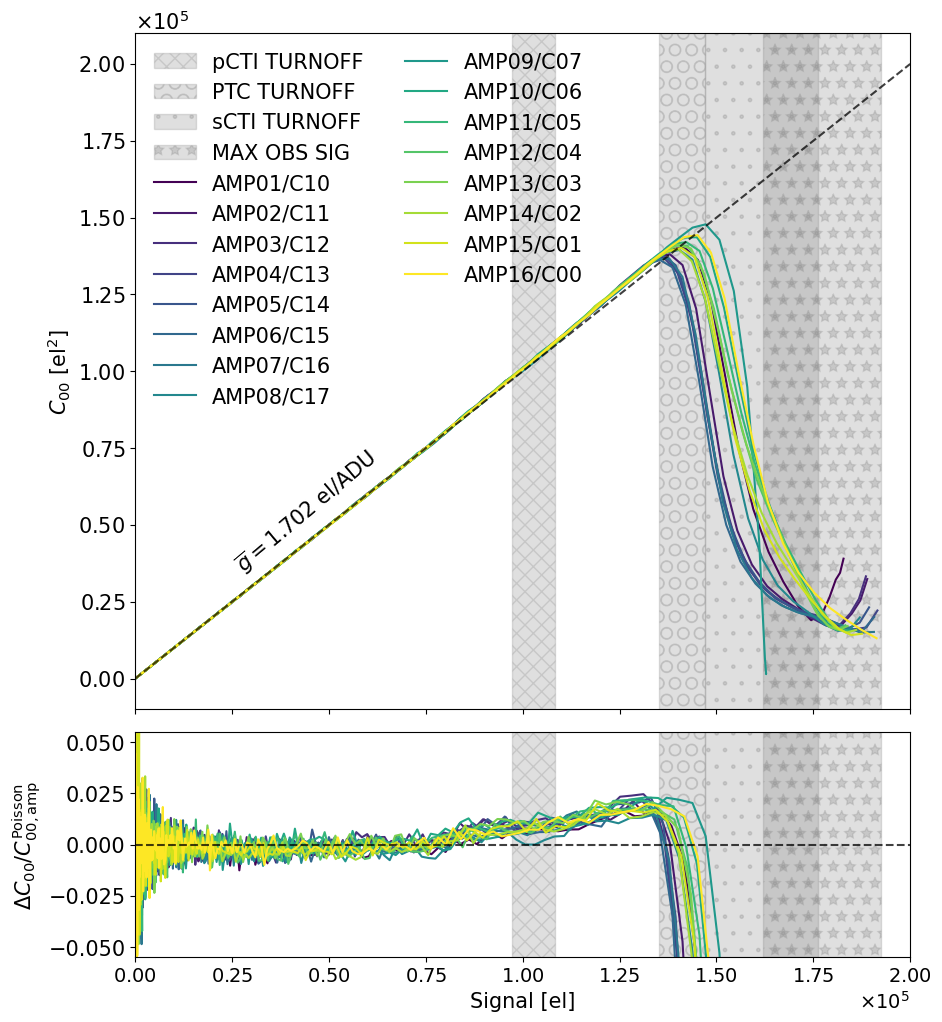

In [6]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

ptc = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.10.09/ptc.R03-S12.bfcorrected.final.nonFluxConserving')

uncorrected_ptc = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.10.09/ptc.R03-S12.trunc_to_pcti')


gains = []

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(10,12), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)

ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, g= getSensorData(sensor='R03_S12', detector=23)
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):
    ptc_turnoffs.append(ptc.ptcTurnoff[amp.getName()] * ptc.gain[amp.getName()])
ax1.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX',color='gray', label = "pCTI TURNOFF")
ax1.axvspan(np.min(ptc_turnoffs) , np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray', label = "PTC TURNOFF")
ax1.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray', label = "sCTI TURNOFF")
ax1.axvspan(np.min(moss), np.max(moss), alpha=0.25, color='gray', hatch='*', label = "MAX OBS SIG")
ax2.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX', color='gray') #, label = "pCTI TURNOFF")
ax2.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray') #, label = "PTC TURNOFF")
ax2.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray') #, label = "sCTI TURNOFF")
ax2.axvspan(np.min(moss), np.max(moss), alpha=0.25, hatch='*', color='gray') #, label = "MAX OBSERVED SIGNAL")

color = cm.viridis(np.linspace(0, 1, 16))
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):


    gains.append(uncorrected_ptc.gain[amp.getName()])
    g = uncorrected_ptc.gain[amp.getName()]
    n = uncorrected_ptc.noiseMatrix[amp.getName()][0][0]
    #n = ptc.noise[amp.getName()]**2

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) #* uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) #* uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    C = C  - n/g**2
    print(C[50], flux[50])
    
    flux = flux*g
    C = C*g**2
    ax1.plot(flux, C , label=slacAmps[amp.getName()] + "/" + amp.getName(), color=color[i])
    ax2.plot(flux, (C - flux) / (flux), color=color[i])
    
    gains.append(ptc.gain[amp.getName()])

    #mask = uncorrected_ptc.expIdMask[amp.getName()]
    #flux = np.asarray(uncorrected_ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    #C    = np.asarray(uncorrected_ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    #ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color="r")
    #ax2.plot(flux, C - (1./np.mean(gains) * flux), color=color[i])


ax1.plot(np.linspace(0.,200000., 10),  np.linspace(0.,200000., 10), "k--", alpha=0.75)


ax1.plot(np.zeros(1), np.zeros([1,4]), color='w', alpha=0, label=' ')

#plt.suptitle("PTC - R02-S00 (ITL) - $C_{00}$\nBF Corrected, $f_{\mathbf{a}}$ (optimal)")
ax2.set_xlabel("Signal [el]")
ax1.set_ylabel("$C_{00}$ [el$^{2}$]")
ax2.set_ylabel("$\Delta C_{00} / C_{00, \mathrm{amp}}^{\mathrm{Poisson}}}$")
ax1.text(25000,35000,r"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " el/ADU", rotation=90-50.)
#ax1.legend(loc='upper left',ncol=2, frameon=False)
ax2.set_xlim(0,200000)
ax2.set_ylim(-.055,.055)
ax2.axhline(0,linestyle="--", color="k", alpha=0.75)
# Format with 2 decimal places
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
#plt.gca().ticklabel_format(useMathText=True)
ax1.legend(ncol=2, frameon=False)
#ax1.set_title("R03-S12 - 60000adu")

plt.savefig("../plots/reconstructed_ptc_R03_S12.png", bbox_inches="tight")


127.70691603191827 184.2571513265968
121.08454310209325 183.3090128905901
123.32077572774156 181.77304184407038
123.01753047984354 180.60365069850988
128.4362380415747 178.8375532327703
119.44414183695659 177.95933558095908
117.61896339134353 176.52783756647838
119.55528016549462 174.73154058854936
110.74255283813336 169.7376960760853
110.15453661503314 168.9070481957581
115.6276919526755 170.35224915220567
113.28000397376042 172.10245089679046
112.10107767475333 172.74644692157466
112.29483025128101 173.98277139244732
113.76021212562381 175.50124745336203
109.35197222405047 175.94400136771532


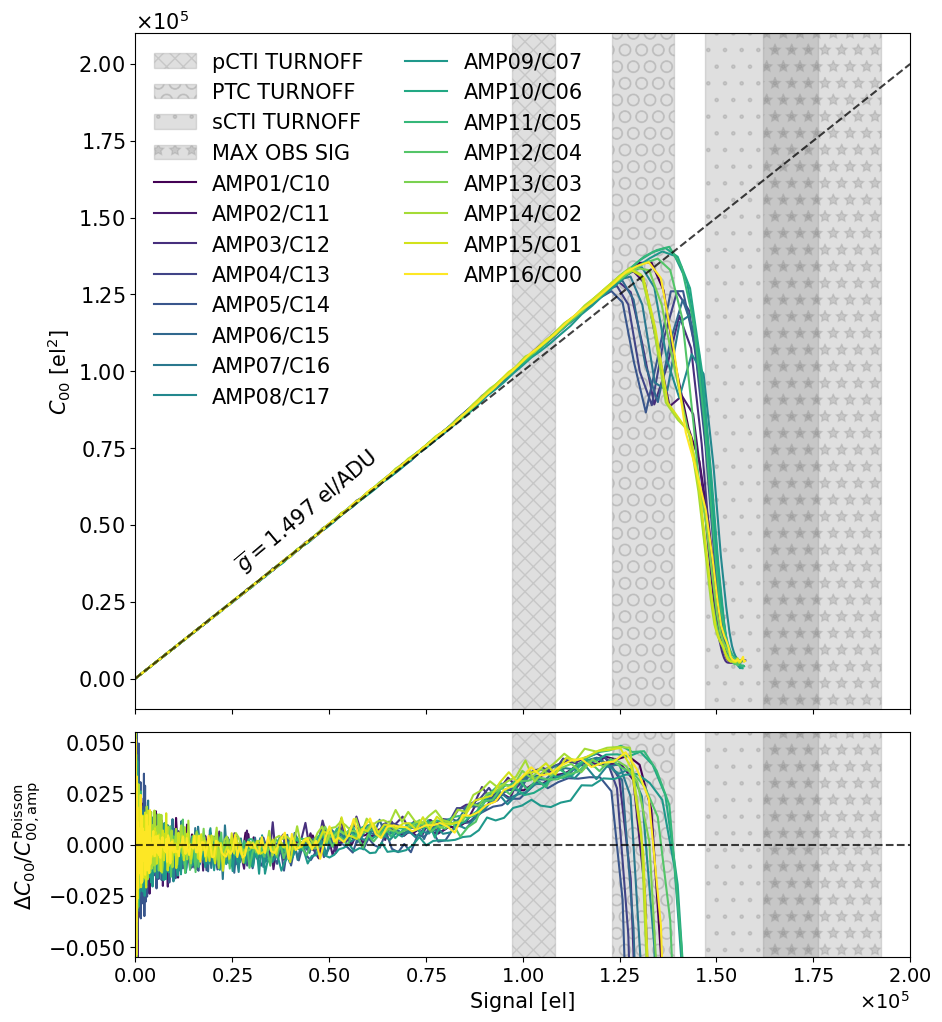

In [7]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

ptc = butler.get('ptc', detector=112, instrument='LSSTCam', collections='u/abrought/BF/2023.10.09/ptc.R24-S11.bfcorrected.final.nonFluxConserving')

uncorrected_ptc = butler.get('ptc', detector=112, instrument='LSSTCam', collections='u/abrought/BF/2023.10.09/ptc.R24-S11.trunc_to_pcti')


gains = []

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(10,12), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)

ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, g= getSensorData(sensor='R03_S12', detector=23)
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):
    ptc_turnoffs.append(ptc.ptcTurnoff[amp.getName()] * ptc.gain[amp.getName()])
ax1.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX',color='gray', label = "pCTI TURNOFF")
ax1.axvspan(np.min(ptc_turnoffs) , np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray', label = "PTC TURNOFF")
ax1.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray', label = "sCTI TURNOFF")
ax1.axvspan(np.min(moss), np.max(moss), alpha=0.25, color='gray', hatch='*', label = "MAX OBS SIG")
ax2.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX', color='gray') #, label = "pCTI TURNOFF")
ax2.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray') #, label = "PTC TURNOFF")
ax2.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray') #, label = "sCTI TURNOFF")
ax2.axvspan(np.min(moss), np.max(moss), alpha=0.25, hatch='*', color='gray') #, label = "MAX OBSERVED SIGNAL")

color = cm.viridis(np.linspace(0, 1, 16))
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):


    gains.append(uncorrected_ptc.gain[amp.getName()])
    g = uncorrected_ptc.gain[amp.getName()]
    n = uncorrected_ptc.noiseMatrix[amp.getName()][0][0]
    #n = ptc.noise[amp.getName()]**2

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) #* uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) #* uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    C = C  - n/g**2
    print(C[50], flux[50])
    
    flux = flux*g
    C = C*g**2
    ax1.plot(flux, C , label=slacAmps[amp.getName()] + "/" + amp.getName(), color=color[i])
    ax2.plot(flux, (C - flux) / (flux), color=color[i])
    
    gains.append(ptc.gain[amp.getName()])

    #mask = uncorrected_ptc.expIdMask[amp.getName()]
    #flux = np.asarray(uncorrected_ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    #C    = np.asarray(uncorrected_ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    #ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color="r")
    #ax2.plot(flux, C - (1./np.mean(gains) * flux), color=color[i])


ax1.plot(np.linspace(0.,200000., 10),  np.linspace(0.,200000., 10), "k--", alpha=0.75)


ax1.plot(np.zeros(1), np.zeros([1,4]), color='w', alpha=0, label=' ')

#plt.suptitle("PTC - R02-S00 (ITL) - $C_{00}$\nBF Corrected, $f_{\mathbf{a}}$ (optimal)")
ax2.set_xlabel("Signal [el]")
ax1.set_ylabel("$C_{00}$ [el$^{2}$]")
ax2.set_ylabel("$\Delta C_{00} / C_{00, \mathrm{amp}}^{\mathrm{Poisson}}}$")
ax1.text(25000,35000,r"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " el/ADU", rotation=90-50.)
#ax1.legend(loc='upper left',ncol=2, frameon=False)
ax2.set_xlim(0,200000)
ax2.set_ylim(-.055,.055)
ax2.axhline(0,linestyle="--", color="k", alpha=0.75)
# Format with 2 decimal places
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
#plt.gca().ticklabel_format(useMathText=True)
ax1.legend(ncol=2, frameon=False)
#ax1.set_title("R03-S12 - 60000adu")

plt.savefig("../plots/reconstructed_ptc_R24_S11.png", bbox_inches="tight")


127.70691603191827 184.2571513265968
121.08454310209325 183.3090128905901
123.32077572774156 181.77304184407038
123.01753047984354 180.60365069850988
128.4362380415747 178.8375532327703
119.44414183695659 177.95933558095908
117.61896339134353 176.52783756647838
119.55528016549462 174.73154058854936
110.74255283813336 169.7376960760853
110.15453661503314 168.9070481957581
115.6276919526755 170.35224915220567
113.28000397376042 172.10245089679046
112.10107767475333 172.74644692157466
112.29483025128101 173.98277139244732
113.76021212562381 175.50124745336203
109.35197222405047 175.94400136771532


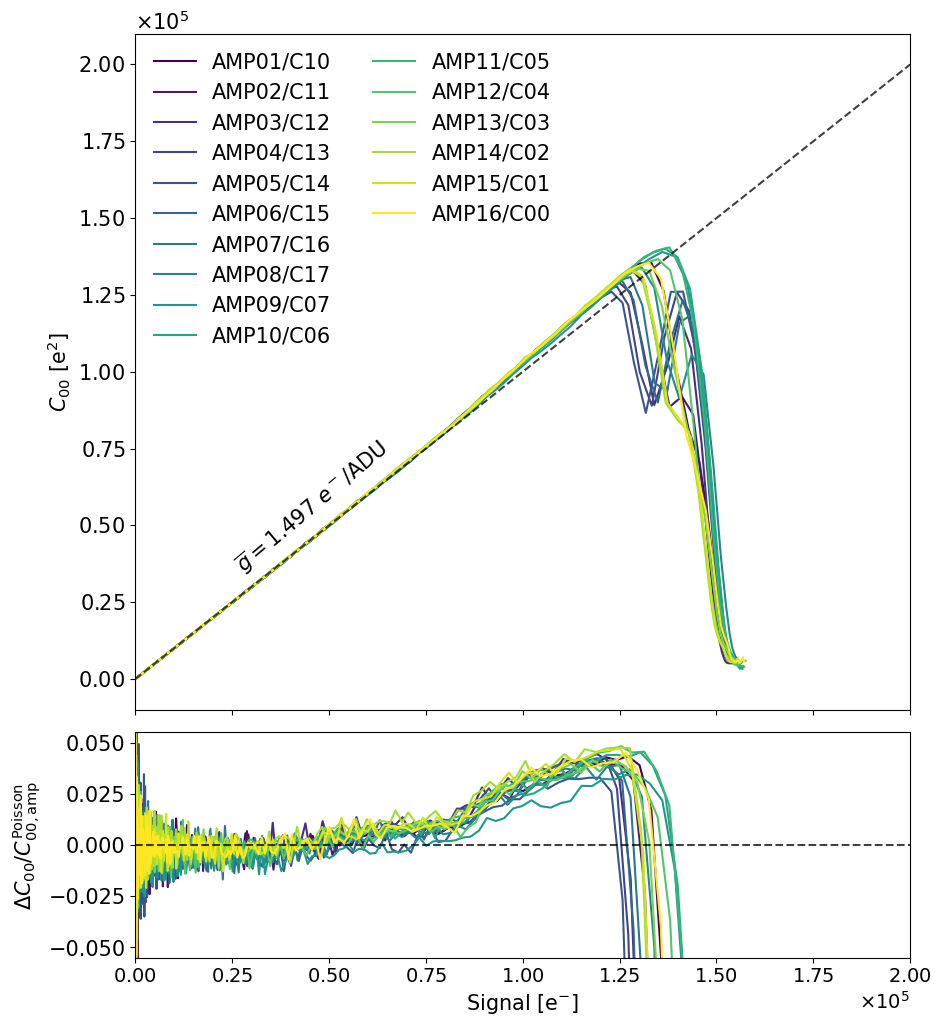

In [7]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

ptc = butler.get('ptc', detector=112, instrument='LSSTCam', collections='u/abrought/BF/2023.10.09/ptc.R24-S11.bfcorrected.final.nonFluxConserving')

uncorrected_ptc = butler.get('ptc', detector=112, instrument='LSSTCam', collections='u/abrought/BF/2023.10.09/ptc.R24-S11.trunc_to_pcti')


gains = []

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(10,12), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)

ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, g= getSensorData(sensor='R03_S12', detector=23)
ptc_turnoffs = []
# for i, amp in enumerate(camera[0].getAmplifiers()):
#     ptc_turnoffs.append(ptc.ptcTurnoff[amp.getName()] * ptc.gain[amp.getName()])
# ax1.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX',color='gray', label = "pCTI TURNOFF")
# ax1.axvspan(np.min(ptc_turnoffs) , np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray', label = "PTC TURNOFF")
# ax1.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray', label = "sCTI TURNOFF")
# ax1.axvspan(np.min(moss), np.max(moss), alpha=0.25, color='gray', hatch='*', label = "MAX OBS SIG")
# ax2.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX', color='gray') #, label = "pCTI TURNOFF")
# ax2.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray') #, label = "PTC TURNOFF")
# ax2.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray') #, label = "sCTI TURNOFF")
# ax2.axvspan(np.min(moss), np.max(moss), alpha=0.25, hatch='*', color='gray') #, label = "MAX OBSERVED SIGNAL")

color = cm.viridis(np.linspace(0, 1, 16))
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):


    gains.append(uncorrected_ptc.gain[amp.getName()])
    g = uncorrected_ptc.gain[amp.getName()]
    n = uncorrected_ptc.noiseMatrix[amp.getName()][0][0]
    #n = ptc.noise[amp.getName()]**2

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) #* uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) #* uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    C = C  - n/g**2
    print(C[50], flux[50])
    
    flux = flux*g
    C = C*g**2
    ax1.plot(flux, C , label=slacAmps[amp.getName()] + "/" + amp.getName(), color=color[i])
    ax2.plot(flux, (C - flux) / (flux), color=color[i])
    
    gains.append(ptc.gain[amp.getName()])

    #mask = uncorrected_ptc.expIdMask[amp.getName()]
    #flux = np.asarray(uncorrected_ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    #C    = np.asarray(uncorrected_ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    #ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color="r")
    #ax2.plot(flux, C - (1./np.mean(gains) * flux), color=color[i])


ax1.plot(np.linspace(0.,200000., 10),  np.linspace(0.,200000., 10), "k--", alpha=0.75)


ax1.plot(np.zeros(1), np.zeros([1,4]), color='w', alpha=0, label=' ')

#plt.suptitle("PTC - R02-S00 (ITL) - $C_{00}$\nBF Corrected, $f_{\mathbf{a}}$ (optimal)")
ax2.set_xlabel("Signal [$\mathrm{e}^{-}$]")
ax1.set_ylabel("$C_{00}$ [$\mathrm{e}^{2}$]")
ax2.set_ylabel("$\Delta C_{00} / C_{00, \mathrm{amp}}^{\mathrm{Poisson}}}$")
ax1.text(25000,35000,r"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " $e^-$/ADU", rotation=90-50.)
#ax1.legend(loc='upper left',ncol=2, frameon=False)
ax2.set_xlim(0,200000)
ax2.set_ylim(-.055,.055)
ax2.axhline(0,linestyle="--", color="k", alpha=0.75)
# Format with 2 decimal places
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
#plt.gca().ticklabel_format(useMathText=True)
ax1.legend(ncol=2, frameon=False)
#ax1.set_title("R03-S12 - 60000adu")

plt.savefig("../plots/reconstructed_ptc_R03_S12.png", bbox_inches="tight")


127.6938650240093 184.25718590302193
121.07332902574674 183.30901259223776
123.31526846871921 181.77304154808655
123.01000089637235 180.60365038047598
128.41623346871515 178.83755291545674
119.43793382679252 177.95933526907908
117.60618366640367 176.52783727368143
119.55128051461135 174.73154024975807
110.74527663311669 169.73769577187988
110.1307606887699 168.9070478967754
115.61045626232213 170.35224884606714
113.26512055613686 172.10245059823237
112.07883397764493 172.7464466296788
112.29468380313051 173.9827710900674
113.76183759987383 175.501247159265
109.35182627520801 175.944001049019


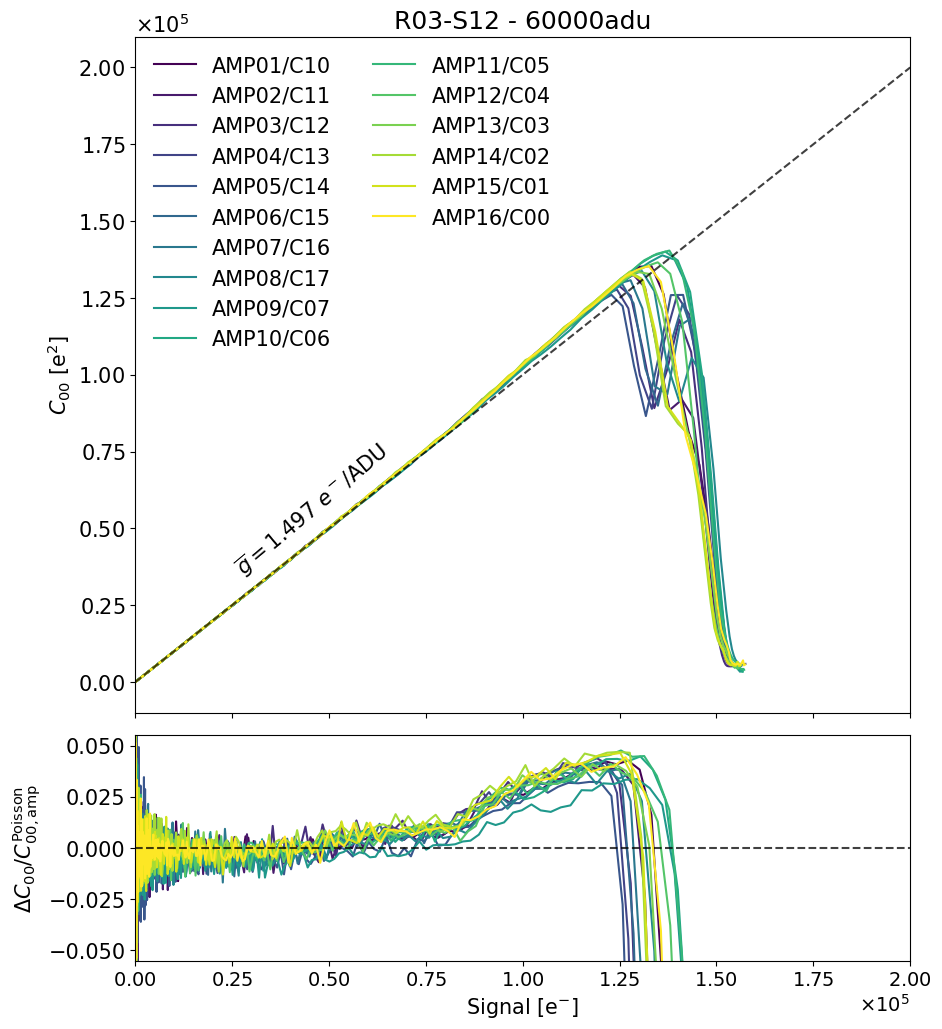

In [12]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

ptc = butler.get('ptc', detector=112, instrument='LSSTCam', collections='u/abrought/BF/2023.10.09/ptc.R24-S11.bfcorrected.20000adu.newpcti.nonFluxConserving.bfThreshold10')

uncorrected_ptc = butler.get('ptc', detector=112, instrument='LSSTCam', collections='u/abrought/BF/2023.07.19/ptc.R24-S11.trunc_to_pcti.fullnoisematrix')


gains = []

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(10,12), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)

ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, g= getSensorData(sensor='R03_S12', detector=23)
ptc_turnoffs = []
# for i, amp in enumerate(camera[0].getAmplifiers()):
#     ptc_turnoffs.append(ptc.ptcTurnoff[amp.getName()] * ptc.gain[amp.getName()])
# ax1.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX',color='gray', label = "pCTI TURNOFF")
# ax1.axvspan(np.min(ptc_turnoffs) , np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray', label = "PTC TURNOFF")
# ax1.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray', label = "sCTI TURNOFF")
# ax1.axvspan(np.min(moss), np.max(moss), alpha=0.25, color='gray', hatch='*', label = "MAX OBS SIG")
# ax2.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX', color='gray') #, label = "pCTI TURNOFF")
# ax2.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray') #, label = "PTC TURNOFF")
# ax2.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray') #, label = "sCTI TURNOFF")
# ax2.axvspan(np.min(moss), np.max(moss), alpha=0.25, hatch='*', color='gray') #, label = "MAX OBSERVED SIGNAL")

color = cm.viridis(np.linspace(0, 1, 16))
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):


    gains.append(uncorrected_ptc.gain[amp.getName()])
    g = uncorrected_ptc.gain[amp.getName()]
    n = uncorrected_ptc.noiseMatrix[amp.getName()][0][0]
    #n = ptc.noise[amp.getName()]**2

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) #* uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) #* uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    C = C  - n/g**2
    print(C[50], flux[50])
    
    flux = flux*g
    C = C*g**2
    ax1.plot(flux, C , label=slacAmps[amp.getName()] + "/" + amp.getName(), color=color[i])
    ax2.plot(flux, (C - flux) / (flux), color=color[i])
    
    gains.append(ptc.gain[amp.getName()])

    #mask = uncorrected_ptc.expIdMask[amp.getName()]
    #flux = np.asarray(uncorrected_ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    #C    = np.asarray(uncorrected_ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    #ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color="r")
    #ax2.plot(flux, C - (1./np.mean(gains) * flux), color=color[i])


ax1.plot(np.linspace(0.,200000., 10),  np.linspace(0.,200000., 10), "k--", alpha=0.75)


ax1.plot(np.zeros(1), np.zeros([1,4]), color='w', alpha=0, label=' ')

#plt.suptitle("PTC - R02-S00 (ITL) - $C_{00}$\nBF Corrected, $f_{\mathbf{a}}$ (optimal)")
ax2.set_xlabel("Signal [$\mathrm{e}^{-}$]")
ax1.set_ylabel("$C_{00}$ [$\mathrm{e}^{2}$]")
ax2.set_ylabel("$\Delta C_{00} / C_{00, \mathrm{amp}}^{\mathrm{Poisson}}}$")
ax1.text(25000,35000,r"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " $e^-$/ADU", rotation=90-50.)
#ax1.legend(loc='upper left',ncol=2, frameon=False)
ax2.set_xlim(0,200000)
ax2.set_ylim(-.055,.055)
ax2.axhline(0,linestyle="--", color="k", alpha=0.75)
# Format with 2 decimal places
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
#plt.gca().ticklabel_format(useMathText=True)
ax1.legend(ncol=2, frameon=False)
ax1.set_title("R03-S12 - 60000adu")

plt.savefig("../plots/reconstructed_ptc_R21_S02.png", bbox_inches="tight")


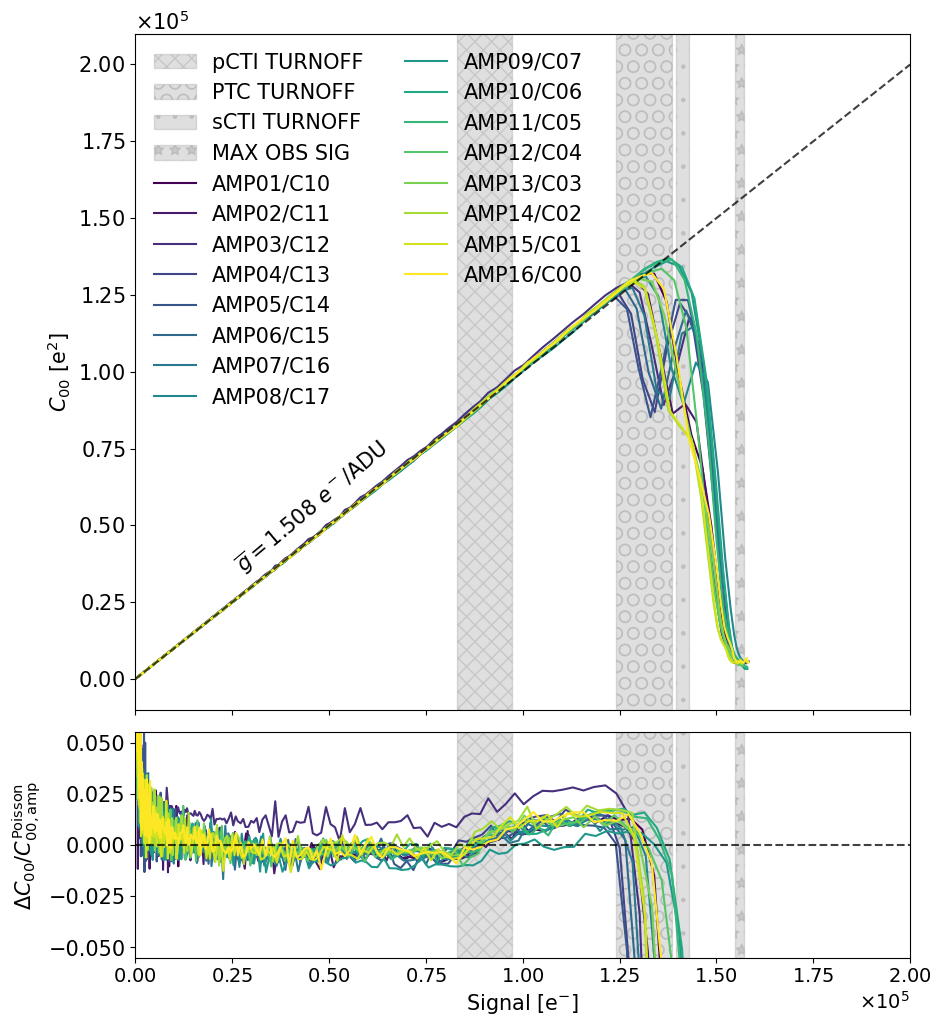

In [6]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

ptc = butler.get('ptc', detector=112, instrument='LSSTCam', collections='u/abrought/BF/2023.09.15/ptc.R24-S11.bfcorrected.final.nonFluxConserving')

uncorrected_ptc = butler.get('ptc', detector=112, instrument='LSSTCam', collections='u/abrought/BF/2023.09.15/ptc.R24-S11.bfcorrected.final.nonFluxConserving')



gains = []

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(10,12), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)

ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, g= getSensorData(sensor='R24_S11', detector=112)
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):
    ptc_turnoffs.append(ptc.ptcTurnoff[amp.getName()] * ptc.gain[amp.getName()])
ax1.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX',color='gray', label = "pCTI TURNOFF")
ax1.axvspan(np.min(ptc_turnoffs) , np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray', label = "PTC TURNOFF")
ax1.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray', label = "sCTI TURNOFF")
ax1.axvspan(np.min(moss), np.max(moss), alpha=0.25, color='gray', hatch='*', label = "MAX OBS SIG")
ax2.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX', color='gray') #, label = "pCTI TURNOFF")
ax2.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray') #, label = "PTC TURNOFF")
ax2.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray') #, label = "sCTI TURNOFF")
ax2.axvspan(np.min(moss), np.max(moss), alpha=0.25, hatch='*', color='gray') #, label = "MAX OBSERVED SIGNAL")

color = cm.viridis(np.linspace(0, 1, 16))
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):


    gains.append(ptc.gain[amp.getName()])

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]
    
    ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color=color[i])
    ax2.plot(flux, (C - flux) / (flux), color=color[i])
    
    gains.append(ptc.gain[amp.getName()])

    #mask = uncorrected_ptc.expIdMask[amp.getName()]
    #flux = np.asarray(uncorrected_ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    #C    = np.asarray(uncorrected_ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    #ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color="r")
    #ax2.plot(flux, C - (1./np.mean(gains) * flux), color=color[i])


ax1.plot(np.linspace(0.,200000., 10),  np.linspace(0.,200000., 10), "k--", alpha=0.75)


ax1.plot(np.zeros(1), np.zeros([1,4]), color='w', alpha=0, label=' ')

#plt.suptitle("PTC - R03-S12 (ITL) - $C_{00}$\nBF Corrected, $f_{\mathbf{a}}$ (optimal)")
ax2.set_xlabel("Signal [$\mathrm{e}^{-}$]")
ax1.set_ylabel("$C_{00}$ [$\mathrm{e}^{2}$]")
ax2.set_ylabel("$\Delta C_{00} / C_{00, \mathrm{amp}}^{\mathrm{Poisson}}}$")
ax1.text(25000,35000,r"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " $e^-$/ADU", rotation=90-50.)
#ax1.legend(loc='upper left',ncol=2, frameon=False)
ax2.set_xlim(0,200000)
ax2.set_ylim(-.055,.055)
ax2.axhline(0,linestyle="--", color="k", alpha=0.75)
# Format with 2 decimal places
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
#plt.gca().ticklabel_format(useMathText=True)
ax1.legend(ncol=2, frameon=False)

plt.savefig("../plots/reconstructed_ptc_R24_S11.png", bbox_inches="tight")


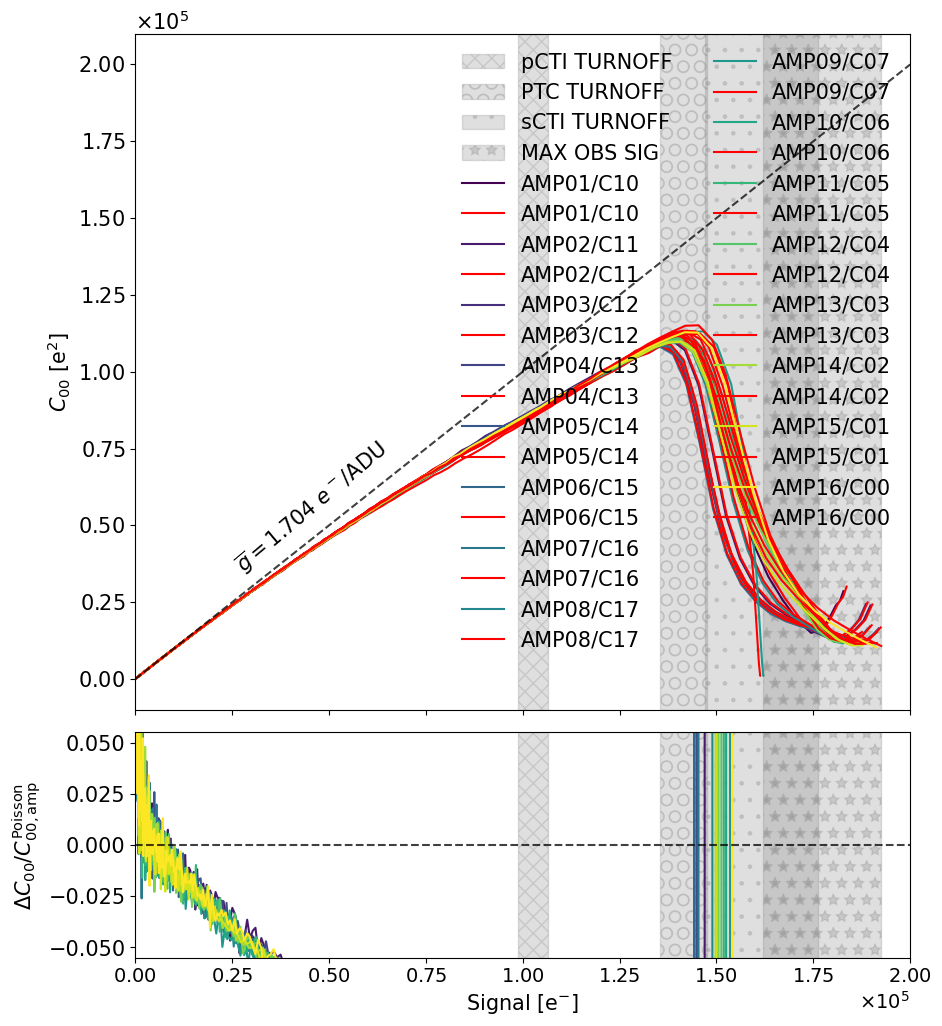

In [11]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

ptc = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.07.19/ptc.R03-S12.bfcorrected.final.fluxConserving')

uncorrected_ptc = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.07.19/ptc.R03-S12.fullnoisematrix')



gains = []

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(10,12), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)

ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, g= getSensorData(sensor='R03_S12', detector=23)
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):
    ptc_turnoffs.append(ptc.ptcTurnoff[amp.getName()] * ptc.gain[amp.getName()])
ax1.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX',color='gray', label = "pCTI TURNOFF")
ax1.axvspan(np.min(ptc_turnoffs) , np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray', label = "PTC TURNOFF")
ax1.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray', label = "sCTI TURNOFF")
ax1.axvspan(np.min(moss), np.max(moss), alpha=0.25, color='gray', hatch='*', label = "MAX OBS SIG")
ax2.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX', color='gray') #, label = "pCTI TURNOFF")
ax2.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray') #, label = "PTC TURNOFF")
ax2.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray') #, label = "sCTI TURNOFF")
ax2.axvspan(np.min(moss), np.max(moss), alpha=0.25, hatch='*', color='gray') #, label = "MAX OBSERVED SIGNAL")

color = cm.viridis(np.linspace(0, 1, 16))
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):


    gains.append(ptc.gain[amp.getName()])

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]
    
    ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color=color[i])
    ax2.plot(flux, (C - flux) / (flux), color=color[i])
    
    gains.append(ptc.gain[amp.getName()])

    mask = uncorrected_ptc.expIdMask[amp.getName()]
    flux = np.asarray(uncorrected_ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(uncorrected_ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color="r")
    ax2.plot(flux, C - (1./np.mean(gains) * flux), color=color[i])


ax1.plot(np.linspace(0.,200000., 10),  np.linspace(0.,200000., 10), "k--", alpha=0.75)


ax1.plot(np.zeros(1), np.zeros([1,4]), color='w', alpha=0, label=' ')

#plt.suptitle("PTC - R03-S12 (ITL) - $C_{00}$\nBF Corrected, $f_{\mathbf{a}}$ (optimal)")
ax2.set_xlabel("Signal [$\mathrm{e}^{-}$]")
ax1.set_ylabel("$C_{00}$ [$\mathrm{e}^{2}$]")
ax2.set_ylabel("$\Delta C_{00} / C_{00, \mathrm{amp}}^{\mathrm{Poisson}}}$")
ax1.text(25000,35000,r"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " $e^-$/ADU", rotation=90-50.)
#ax1.legend(loc='upper left',ncol=2, frameon=False)
ax2.set_xlim(0,200000)
ax2.set_ylim(-.055,.055)
ax2.axhline(0,linestyle="--", color="k", alpha=0.75)
# Format with 2 decimal places
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
#plt.gca().ticklabel_format(useMathText=True)
ax1.legend(ncol=2, frameon=False)

plt.savefig("../plots/reconstructed_ptc_R03_S12_fluxConserving.png", bbox_inches="tight")


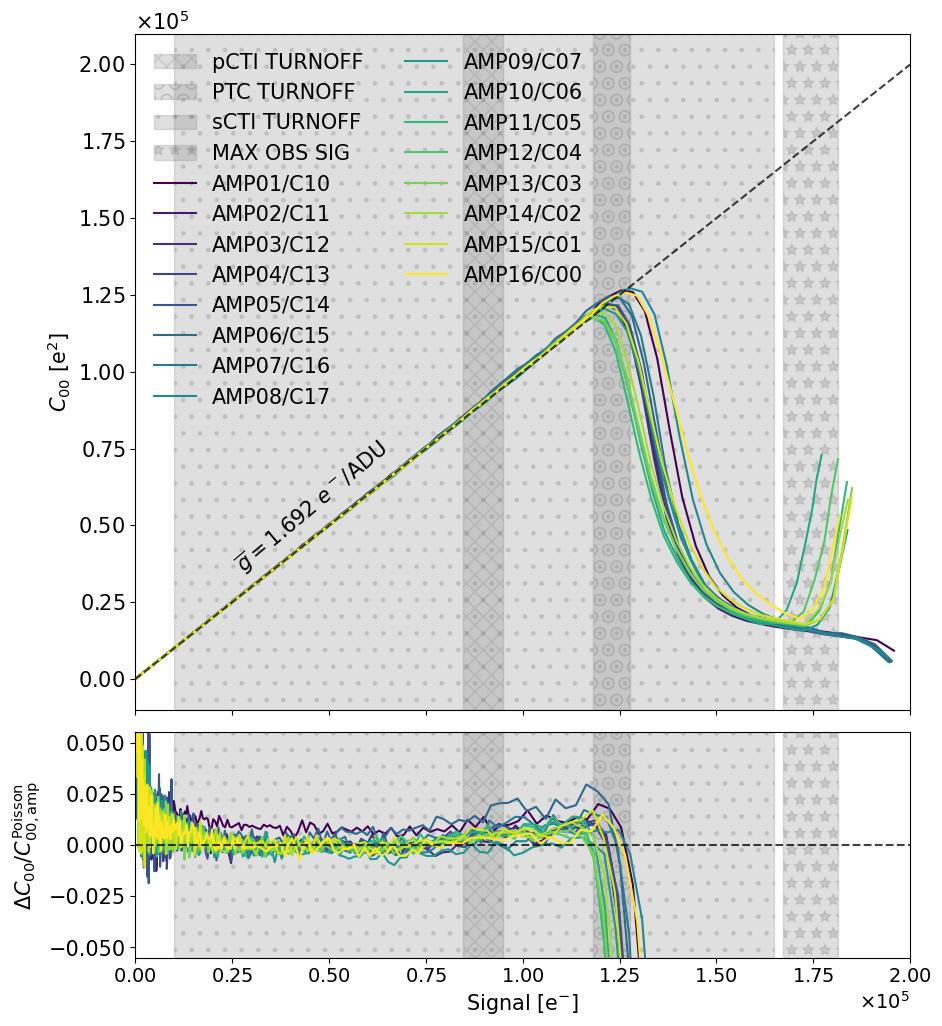

In [7]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

ptc = butler.get('ptc', detector=9, instrument='LSSTCam', collections='u/abrought/BF/2023.07.19/ptc.R02-S00.bfcorrected.final.nonFluxConserving')

uncorrected_ptc = butler.get('ptc', detector=9, instrument='LSSTCam', collections='u/abrought/BF/2023.07.19/ptc.R02-S00.bfcorrected.final.nonFluxConserving')



gains = []

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(10,12), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)

ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, g= getSensorData(sensor='R02_S00', detector=9)
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):
    ptc_turnoffs.append(ptc.ptcTurnoff[amp.getName()] * ptc.gain[amp.getName()])
ax1.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX',color='gray', label = "pCTI TURNOFF")
ax1.axvspan(np.min(ptc_turnoffs) , np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray', label = "PTC TURNOFF")
ax1.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray', label = "sCTI TURNOFF")
ax1.axvspan(np.min(moss), np.max(moss), alpha=0.25, color='gray', hatch='*', label = "MAX OBS SIG")
ax2.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX', color='gray') #, label = "pCTI TURNOFF")
ax2.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray') #, label = "PTC TURNOFF")
ax2.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray') #, label = "sCTI TURNOFF")
ax2.axvspan(np.min(moss), np.max(moss), alpha=0.25, hatch='*', color='gray') #, label = "MAX OBSERVED SIGNAL")

color = cm.viridis(np.linspace(0, 1, 16))
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):


    gains.append(ptc.gain[amp.getName()])

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]
    
    ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color=color[i])
    ax2.plot(flux, (C - flux) / (flux), color=color[i])
    
    gains.append(ptc.gain[amp.getName()])

    #mask = uncorrected_ptc.expIdMask[amp.getName()]
    #flux = np.asarray(uncorrected_ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    #C    = np.asarray(uncorrected_ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    #ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color="r")
    #ax2.plot(flux, C - (1./np.mean(gains) * flux), color=color[i])


ax1.plot(np.linspace(0.,200000., 10),  np.linspace(0.,200000., 10), "k--", alpha=0.75)


ax1.plot(np.zeros(1), np.zeros([1,4]), color='w', alpha=0, label=' ')

#plt.suptitle("PTC - R03-S12 (ITL) - $C_{00}$\nBF Corrected, $f_{\mathbf{a}}$ (optimal)")
ax2.set_xlabel("Signal [$\mathrm{e}^{-}$]")
ax1.set_ylabel("$C_{00}$ [$\mathrm{e}^{2}$]")
ax2.set_ylabel("$\Delta C_{00} / C_{00, \mathrm{amp}}^{\mathrm{Poisson}}}$")
ax1.text(25000,35000,r"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " $e^-$/ADU", rotation=90-50.)
#ax1.legend(loc='upper left',ncol=2, frameon=False)
ax2.set_xlim(0,200000)
ax2.set_ylim(-.055,.055)
ax2.axhline(0,linestyle="--", color="k", alpha=0.75)
# Format with 2 decimal places
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
#plt.gca().ticklabel_format(useMathText=True)
ax1.legend(ncol=2, frameon=False)

plt.savefig("../plots/reconstructed_ptc_R02_S00.png", bbox_inches="tight")


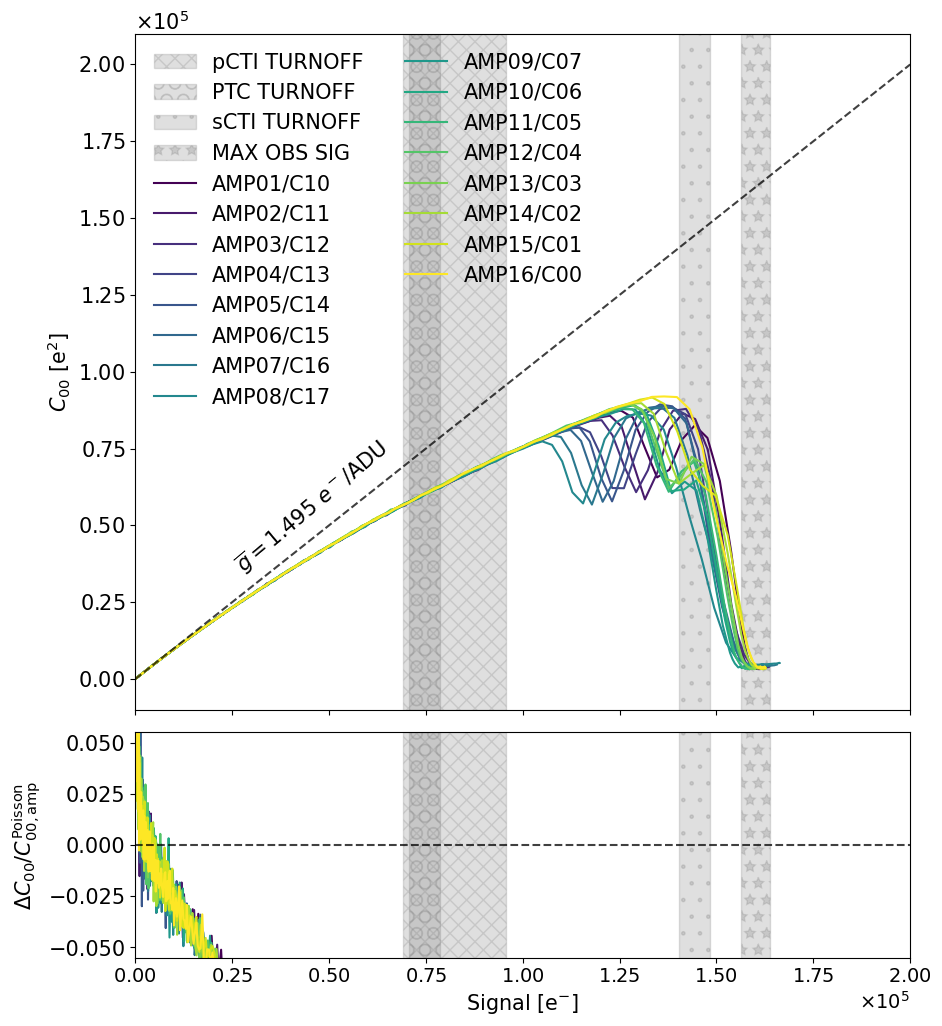

In [8]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

ptc = butler.get('ptc', detector=83, instrument='LSSTCam', collections='u/abrought/BF/2023.07.19/ptc.R21-S02.bfcorrected.final.nonFluxConserving')

uncorrected_ptc = butler.get('ptc', detector=83, instrument='LSSTCam', collections='u/abrought/BF/2023.07.19/ptc.R21-S02.bfcorrected.final.nonFluxConserving')



gains = []

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(10,12), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)

ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, g= getSensorData(sensor='R21_S02', detector=83)
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):
    ptc_turnoffs.append(ptc.ptcTurnoff[amp.getName()] * ptc.gain[amp.getName()])
ax1.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX',color='gray', label = "pCTI TURNOFF")
ax1.axvspan(np.min(ptc_turnoffs) , np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray', label = "PTC TURNOFF")
ax1.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray', label = "sCTI TURNOFF")
ax1.axvspan(np.min(moss), np.max(moss), alpha=0.25, color='gray', hatch='*', label = "MAX OBS SIG")
ax2.axvspan(np.min(pcti_turnoffs), np.max(pcti_turnoffs), alpha=0.25, hatch='XX', color='gray') #, label = "pCTI TURNOFF")
ax2.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.25, hatch='O', color='gray') #, label = "PTC TURNOFF")
ax2.axvspan(np.min(scti_turnoffs), np.max(scti_turnoffs), alpha=0.25, hatch='.', color='gray') #, label = "sCTI TURNOFF")
ax2.axvspan(np.min(moss), np.max(moss), alpha=0.25, hatch='*', color='gray') #, label = "MAX OBSERVED SIGNAL")

color = cm.viridis(np.linspace(0, 1, 16))
ptc_turnoffs = []
for i, amp in enumerate(camera[0].getAmplifiers()):


    gains.append(ptc.gain[amp.getName()])

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]
    
    ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color=color[i])
    ax2.plot(flux, (C - flux) / (flux), color=color[i])
    
    gains.append(ptc.gain[amp.getName()])

    #mask = uncorrected_ptc.expIdMask[amp.getName()]
    #flux = np.asarray(uncorrected_ptc.rawMeans[amp.getName()]) * uncorrected_ptc.gain[amp.getName()]
    #C    = np.asarray(uncorrected_ptc.rawVars[amp.getName()]) * uncorrected_ptc.gain[amp.getName()] * uncorrected_ptc.gain[amp.getName()]

    #ax1.plot(flux, C, label=slacAmps[amp.getName()] + "/" + amp.getName(), color="r")
    #ax2.plot(flux, C - (1./np.mean(gains) * flux), color=color[i])


ax1.plot(np.linspace(0.,200000., 10),  np.linspace(0.,200000., 10), "k--", alpha=0.75)


ax1.plot(np.zeros(1), np.zeros([1,4]), color='w', alpha=0, label=' ')

#plt.suptitle("PTC - R03-S12 (ITL) - $C_{00}$\nBF Corrected, $f_{\mathbf{a}}$ (optimal)")
ax2.set_xlabel("Signal [$\mathrm{e}^{-}$]")
ax1.set_ylabel("$C_{00}$ [$\mathrm{e}^{2}$]")
ax2.set_ylabel("$\Delta C_{00} / C_{00, \mathrm{amp}}^{\mathrm{Poisson}}}$")
ax1.text(25000,35000,r"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " $e^-$/ADU", rotation=90-50.)
#ax1.legend(loc='upper left',ncol=2, frameon=False)
ax2.set_xlim(0,200000)
ax2.set_ylim(-.055,.055)
ax2.axhline(0,linestyle="--", color="k", alpha=0.75)
# Format with 2 decimal places
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
#plt.gca().ticklabel_format(useMathText=True)
ax1.legend(ncol=2, frameon=False)

plt.savefig("../plots/reconstructed_ptc_212_S02.png", bbox_inches="tight")


## $a_{ij}$ matrix offset factor determination

In [4]:
def get_data_points(sensor):
    from scipy.stats import chisquare
    print("here")
                                                                      #2023.06.16
    collections = os.listdir("/sdf/group/rubin/repo/main/u/abrought/BF/2023.06.16/")
    collections = [f for f in collections if "ptc" in f and sensor in f]
    collections = [f for f in collections if "scalefactor" in f]
    collections = [f for f in collections if "yousukefixes" not in f]
            
                                         #2023.06.16
    collections = np.sort(["u/abrought/BF/2023.06.16/" + f for f in collections])
    print(collections)
    factors = np.asarray([float("0." + col[63:]) for col in collections]) # 72:

    print("1", factors)
    sensorid = sensor.replace("-","_")
    det = camera.get(sensorid).getId()

    uncorrected_ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=f'u/abrought/BF/2023.04.28/ptc.2023.04.28.{sensor}.trunc_to_pcti'.format(sensor))
    avg_uncorrected_gain = np.mean([g for _,g in uncorrected_ptc.gain.items()])

    chisqs = []
    for j, collection in enumerate(collections):
        ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections=collection)

        chisq = 0
        for i, amp in enumerate(camera[0].getAmplifiers()):
            mask = np.asarray(ptc.rawMeans[amp.getName()]) < 5.0e4
            obs = np.asarray(ptc.covariancesModel[amp.getName()])[mask][:,0,0]
            exp = 1./uncorrected_ptc.gain[amp.getName()] * np.asarray(ptc.rawMeans[amp.getName()])[mask]
            chisq += np.sum((obs - exp)**2 / exp)

        chisqs.append(chisq / len(obs.ravel()))

    print("2", factors)
    chisqs = np.asarray(chisqs)
    factors = np.asarray(factors)
    print("3", factors)
    
    mask = chisqs < 1e6 # 400\
    chisqs = chisqs[mask]
    factors = factors[mask]
    print("4", factors)
    def f(x,a,b,c):
        return a*x**2 + b*x + c
    print("5", factors)
    x = np.linspace(np.min(factors), np.max(factors), 10000)
    popt, pcov = curve_fit(f, np.asarray(factors), chisqs)
    a,b,c = popt
    
    return factors, chisqs, (a,b,c)
    

here
['u/abrought/BF/2023.06.16/ptc.R03-S12.bfcorrected.scalefactor-0_6'
 'u/abrought/BF/2023.06.16/ptc.R03-S12.bfcorrected.scalefactor-0_7'
 'u/abrought/BF/2023.06.16/ptc.R03-S12.bfcorrected.scalefactor-0_8'
 'u/abrought/BF/2023.06.16/ptc.R03-S12.bfcorrected.scalefactor-0_9']
1 [0.6 0.7 0.8 0.9]
2 [0.6 0.7 0.8 0.9]
3 [0.6 0.7 0.8 0.9]
4 [0.6 0.7 0.8 0.9]
5 [0.6 0.7 0.8 0.9]
here
['u/abrought/BF/2023.06.16/ptc.R24-S11.bfcorrected.scalefactor-0_6'
 'u/abrought/BF/2023.06.16/ptc.R24-S11.bfcorrected.scalefactor-0_7'
 'u/abrought/BF/2023.06.16/ptc.R24-S11.bfcorrected.scalefactor-0_9']
1 [0.6 0.7 0.9]
2 [0.6 0.7 0.9]
3 [0.6 0.7 0.9]
4 [0.6 0.7 0.9]
5 [0.6 0.7 0.9]
here
['u/abrought/BF/2023.06.16/ptc.R02-S00.bfcorrected.scalefactor-0_6'
 'u/abrought/BF/2023.06.16/ptc.R02-S00.bfcorrected.scalefactor-0_7'
 'u/abrought/BF/2023.06.16/ptc.R02-S00.bfcorrected.scalefactor-0_8'
 'u/abrought/BF/2023.06.16/ptc.R02-S00.bfcorrected.scalefactor-0_9']
1 [0.6 0.7 0.8 0.9]


/sdf/group/rubin/sw/conda/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


2 [0.6 0.7 0.8 0.9]
3 [0.6 0.7 0.8 0.9]
4 [0.6 0.7 0.8 0.9]
5 [0.6 0.7 0.8 0.9]
here
['u/abrought/BF/2023.06.16/ptc.R21-S02.bfcorrected.scalefactor-0_6'
 'u/abrought/BF/2023.06.16/ptc.R21-S02.bfcorrected.scalefactor-0_7'
 'u/abrought/BF/2023.06.16/ptc.R21-S02.bfcorrected.scalefactor-0_8'
 'u/abrought/BF/2023.06.16/ptc.R21-S02.bfcorrected.scalefactor-0_9']
1 [0.6 0.7 0.8 0.9]
2 [0.6 0.7 0.8 0.9]
3 [0.6 0.7 0.8 0.9]
4 [0.6 0.7 0.8 0.9]
5 [0.6 0.7 0.8 0.9]


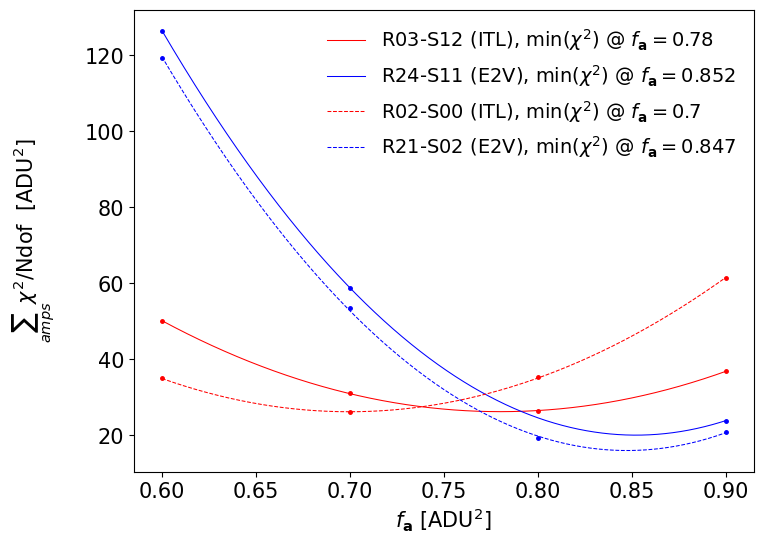

In [5]:
sensors = [ 'R03-S12','R24-S11', 'R02-S00', 'R21-S02']
sensortype = ['(ITL)', '(E2V)','(ITL)','(E2V)']
colors  = ['r', 'b', 'r', 'b']
linefmt = [ "-", "-", "--", "--"]

plt.figure(figsize=(8,6))
for i, sensor in enumerate(sensors):
    factors, chisqs, (A,B,C) = get_data_points(sensor)
    plt.plot(factors, chisqs,"o", ms=2.5,color=colors[i])
    x = np.linspace(np.min(factors), np.max(factors), 10000)
    label = f"{sensor} {sensortype[i]}, min($\chi^2$) @ $f_\mathbf{{a}} = ${round(x[np.argmin(A*x**2 + B*x + C)], 3)}"
    plt.plot(x, A*x**2 + B*x + C, color=colors[i], linestyle=linefmt[i], linewidth=0.75, label=label)
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel(r'$\sum_{amps}\chi^2 /$Ndof  [ADU$^2$]', rotation=90, labelpad=20)
plt.xlabel('$f_{\mathbf{a}}$ [ADU$^2$]')
plt.legend(frameon=False, fontsize=14)
plt.savefig("/sdf/home/a/abrought/run5/BF/plots/scalefactor_ptc_scan_v2.png", bbox_inches='tight')


# Original Scan (Test)

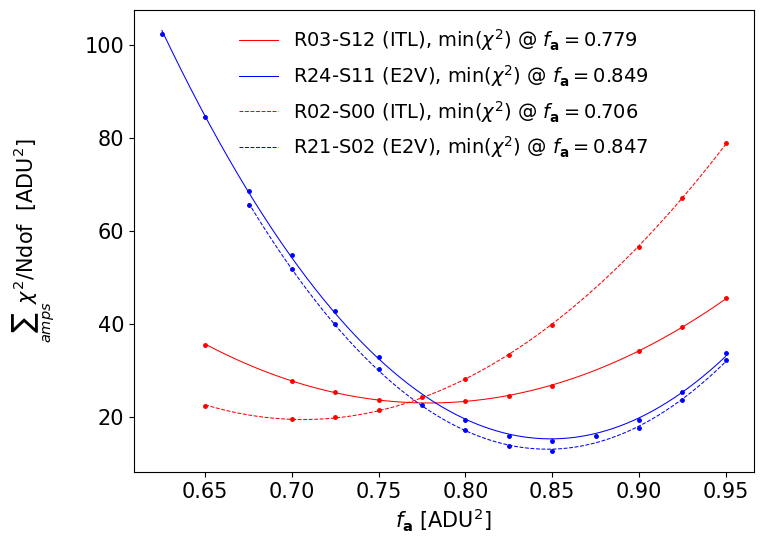

In [4]:
sensors = [ 'R03-S12', 'R24-S11', 'R02-S00', 'R21-S02']
sensortype = ['(ITL)', '(E2V)','(ITL)','(E2V)']
colors  = ['r', 'b', 'r', 'b']
linefmt = [ "-", "-", "--", "--"]

plt.figure(figsize=(8,6))
for i, sensor in enumerate(sensors):
    factors, chisqs, (A,B,C) = get_data_points(sensor)
    plt.plot(factors, chisqs,"o", ms=2.5,color=colors[i])
    x = np.linspace(np.min(factors), np.max(factors), 10000)
    label = f"{sensor} {sensortype[i]}, min($\chi^2$) @ $f_\mathbf{{a}} = ${round(x[np.argmin(A*x**2 + B*x + C)], 3)}"
    plt.plot(x, A*x**2 + B*x + C, color=colors[i], linestyle=linefmt[i], linewidth=0.75, label=label)
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel(r'$\sum_{amps}\chi^2 /$Ndof  [ADU$^2$]', rotation=90, labelpad=20)
plt.xlabel('$f_{\mathbf{a}}$ [ADU$^2$]')
plt.legend(frameon=False, fontsize=14)
plt.savefig("/home/a/abrought/run5/BF/plots/scalefactor_ptc_scan.png", bbox_inches='tight')
